# ECSE415 - Into to Computer Vision
## Assignment 4
### Alexander Harris - 260688155

## 1 - Data Acquisition

In [1]:
import cv2
import numpy as np
import os
import math
import time
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def plotFigures(images, labels=None, title=None):
    """
    Plots images from list in grid.
    
    images: list of images
    title: title for each subplot
    params: specific arguments to add to title
    """
    grid_len = math.ceil(math.sqrt(len(images)))
    plt.figure(figsize=(30,30))
    i = 0
    seq = 1
    tmp = ''
    if labels:
        for image, label in zip(images, labels):
            plt.subplot(grid_len, grid_len, i+1), plt.imshow(image, 'gray')
            if label != tmp:
                seq = 1
            plt.title(f'{label} - #{seq}'), plt.axis('off')
            tmp = label
            i += 1
            seq += 1
    else:
        for image in images:
            plt.subplot(grid_len, grid_len, i+1), plt.imshow(image, 'gray')
            plt.title(f'{title} - #{i+1}'), plt.axis('off')
            i += 1
    plt.show()

In [3]:
def extract_face(img, class_face, size):
    """
    Crop face from original image and resize.
    
    img: image to crop
    class_face: classifier to use
    """
    detect = class_face.detectMultiScale(img, 1.1, 4)
    x, y, w, h = detect[0]
    face = img[y:y+h, x:x+w]
    face_resized = cv2.resize(face, size)
    return face_resized

In [4]:
# Classifier used for testing and prepping training data
face_cascade = cv2.CascadeClassifier(os.path.join(cv2.data.haarcascades, 'haarcascade_frontalface_default.xml'))

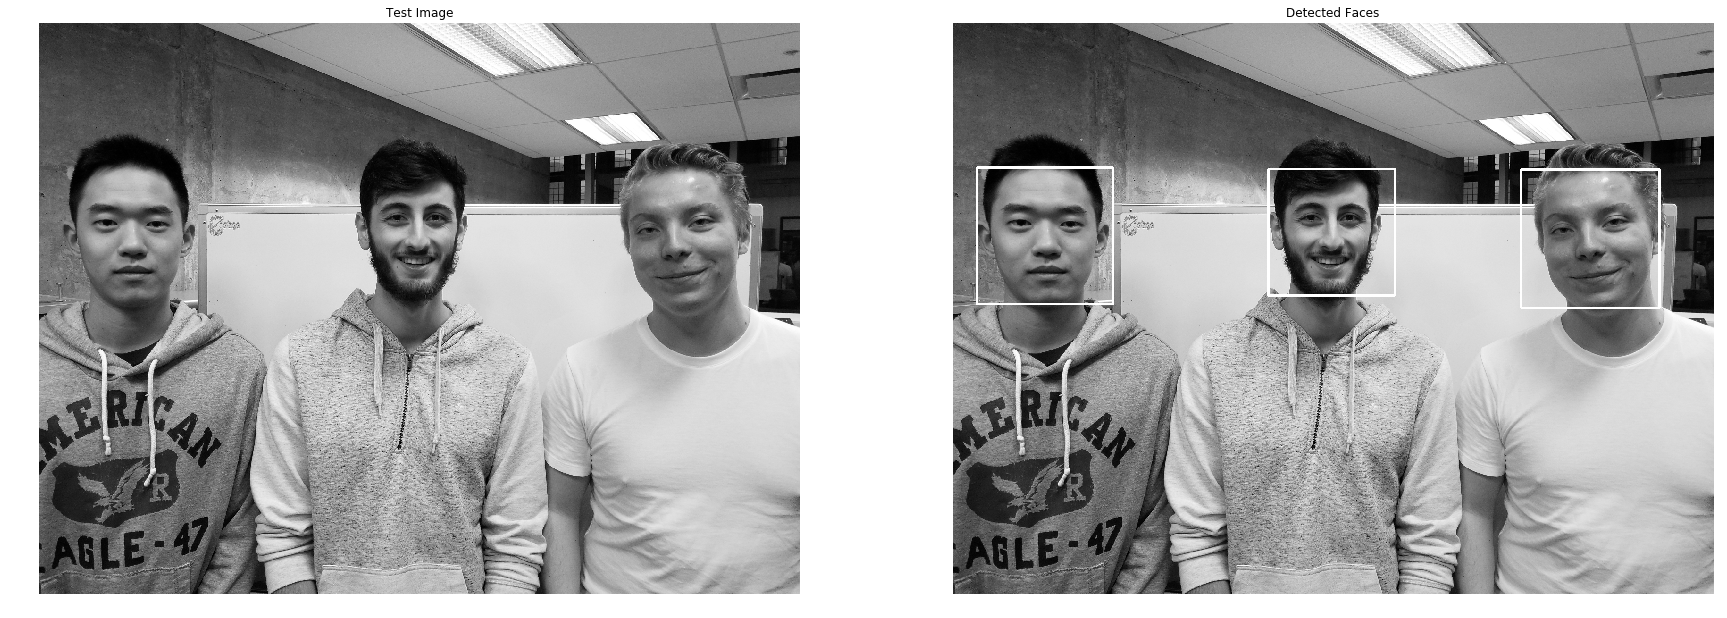

In [5]:
# Show faces detected in test image
test_path = './dataset/test/'
test_file = os.listdir(test_path)[1]
test_img = cv2.imread(test_path + test_file, cv2.IMREAD_GRAYSCALE)
test_img_resized = cv2.resize(test_img, None, fx=0.4, fy=0.4)
test_faces = face_cascade.detectMultiScale(test_img_resized, 1.3, 4)

detected_faces = test_img_resized.copy()
test_detected_faces = []
for (x, y, w, h) in test_faces:
    cv2.rectangle(detected_faces, (x,y), (x+w,y+h), (255,255,255), 4)
    test_detected_faces.append(cv2.resize(test_img_resized[y:y+h, x:x+w], (256,256)))

plt.figure(figsize=(30,30))
plt.subplot(121), plt.title('Test Image')
plt.imshow(test_img_resized, cmap='gray'), plt.axis('off')
plt.subplot(122), plt.title('Detected Faces')
plt.imshow(detected_faces, cmap='gray'), plt.axis('off')
plt.show()

In [6]:
# Import training images and crop around faces
train_path = './dataset/train/'
train_classes = os.listdir(train_path)

train_faces = []
train_labels = []
face_size = (256,256)
for train_class in train_classes:
    filenames = os.listdir(train_path + train_class + '/')
    for i, file in enumerate(filenames):
        img = cv2.imread(f'{train_path}{train_class}/{file}', cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, None, fx=0.5, fy=0.5)
        face = extract_face(img_resized, face_cascade, face_size)
        train_faces.append(face)
        train_labels.append(train_class)

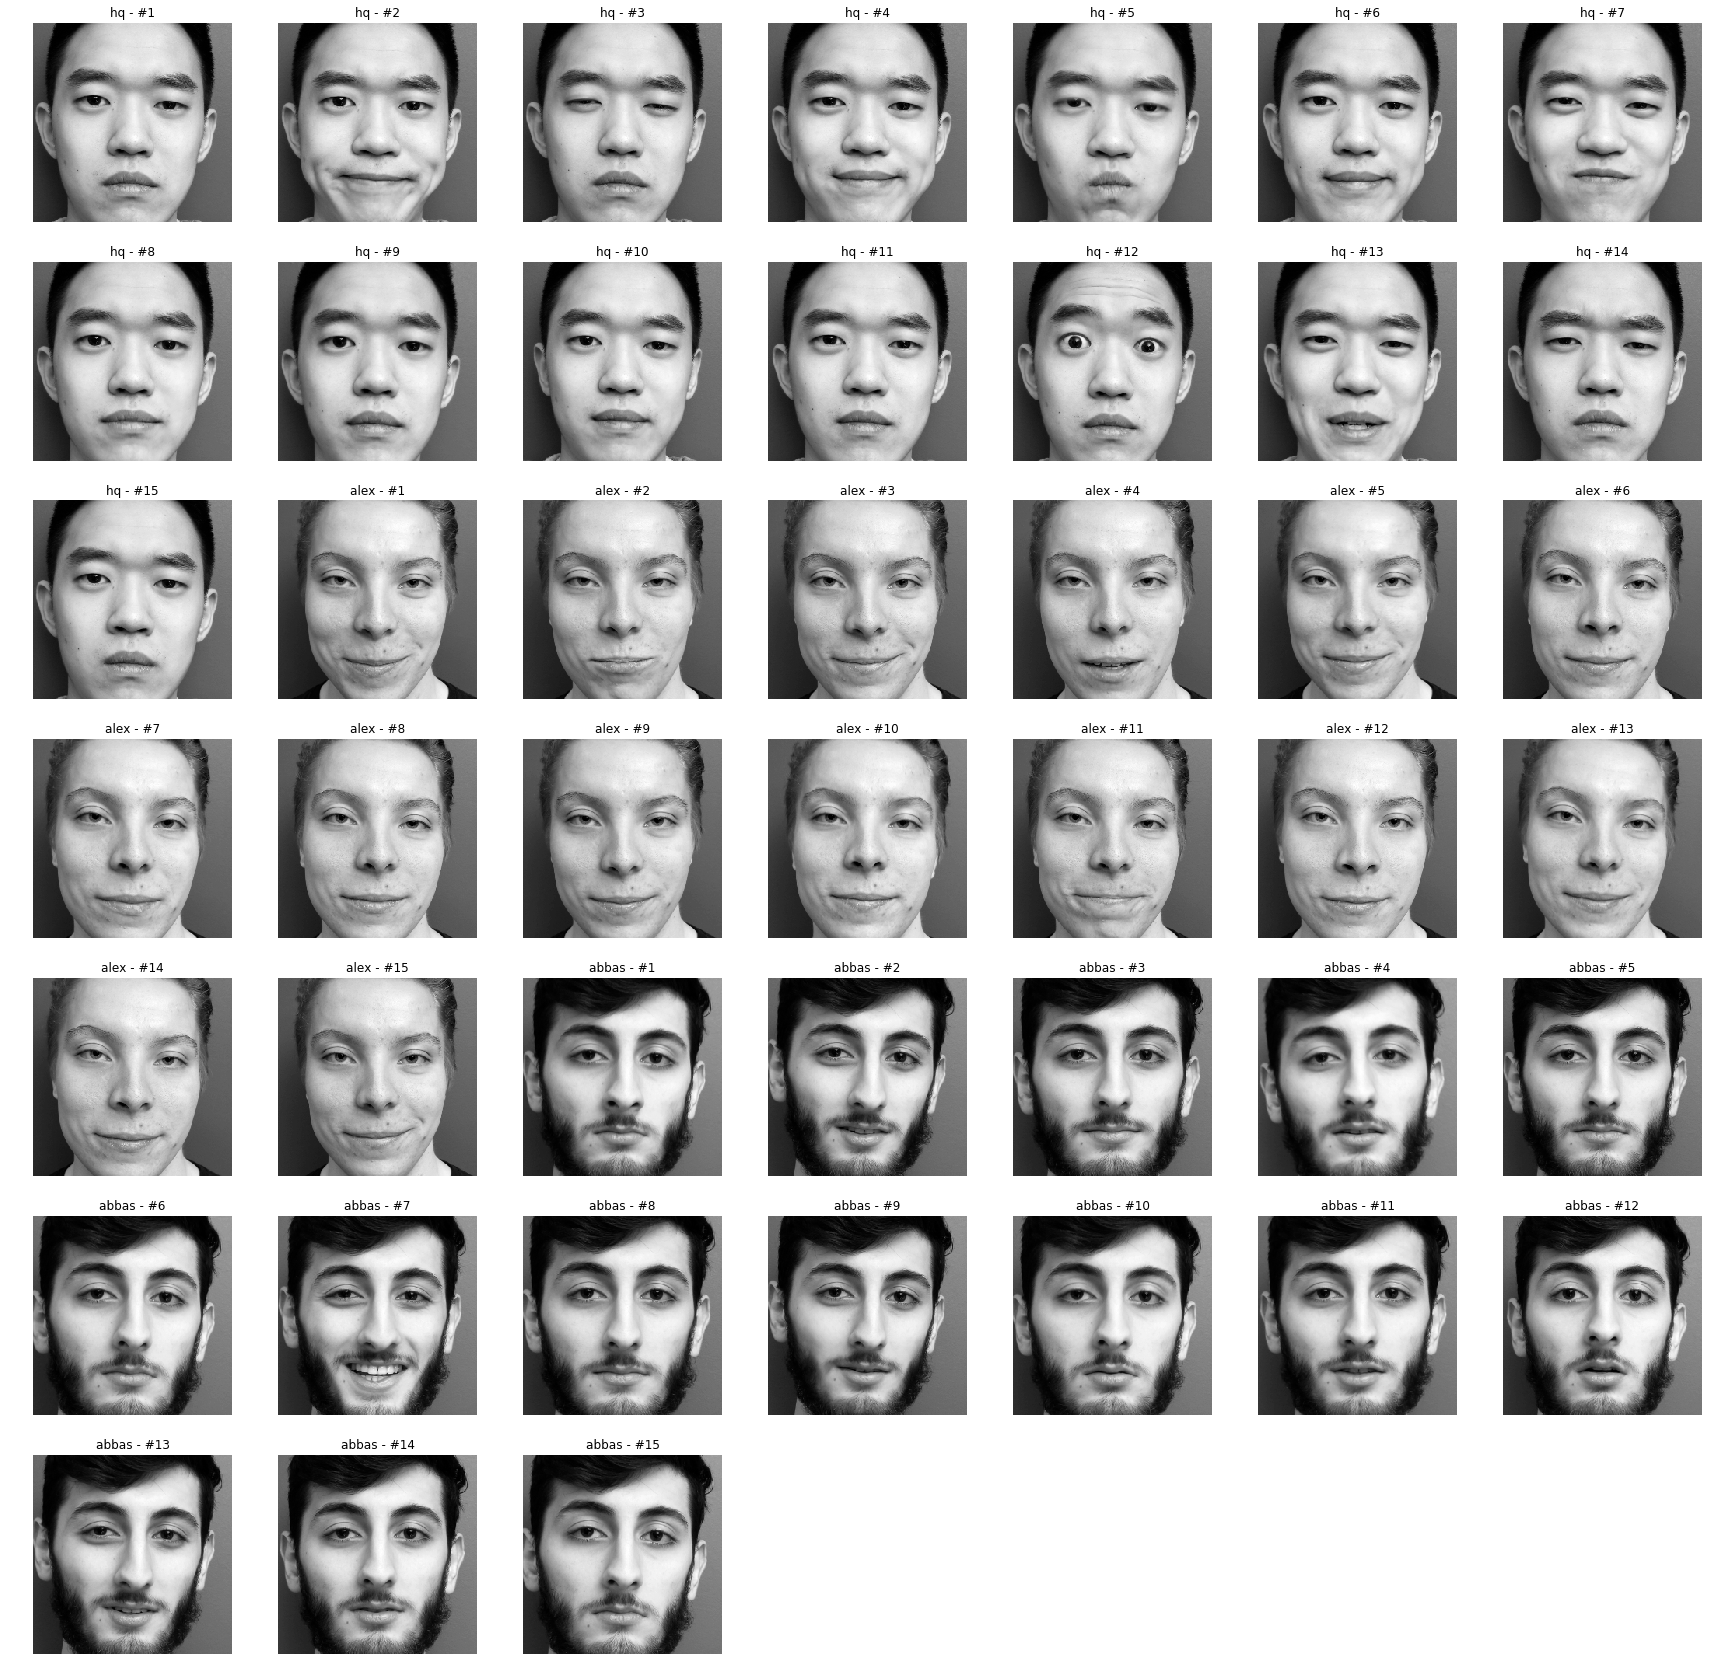

In [7]:
plotFigures(train_faces, train_labels)

We tried to select images that matched the faces from the group image as much as possible. Thats is to say, since the group picture was taken close to a decade ago, we needed to make sure we sourced pictures of the individual actors from the same time-period, with similar facial hair, facial expressions, hairstyle, eyewear, etc. We also made sure to not select pictures with significant occlusion from hands or head position.

## 2 - Eigenvector Representation

In [8]:
# Convert to numpy arrays and reshape images from 2D arrays to vectors
x_train = np.float64(train_faces)
y_train = np.array(train_labels)

x_train = x_train.reshape(x_train.shape[0], -1)

#Normalize data
# scaler = StandardScaler()
# x_train_norm = scaler.fit_transform(x_train)
x_train_norm = x_train

In [9]:
# Compute PCA over range of components
pca_comp = range(1, 46)
variance_ratio = []
for comp in pca_comp:
    pca = PCA(n_components=comp, whiten=True)

    # Compute PCA
    x_train_pca = pca.fit_transform(x_train_norm)
    
#     print(f'Number of components: {comp}')
#     print(f'PCA Dimensions: {x_train_pca.shape}')
#     print(f'PCA Variance Ratio: {pca.explained_variance_ratio_[-1]}\n')
    variance_ratio.append(pca.explained_variance_ratio_[-1])

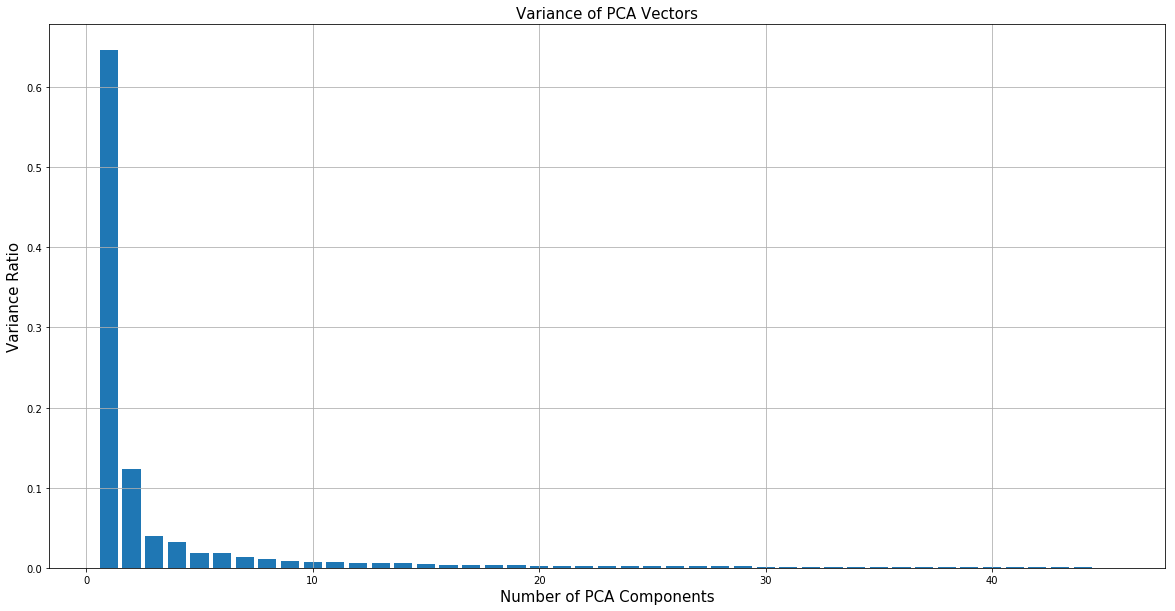

In [10]:
# Plot PCA variance ratio vs number of PCA components
plt.figure(figsize=(20,10))
plt.bar(pca_comp, variance_ratio)
plt.title('Variance of PCA Vectors', fontsize=15)
plt.xlabel('Number of PCA Components', fontsize=15)
plt.ylabel('Variance Ratio', fontsize=15)
plt.grid(True)
plt.show()

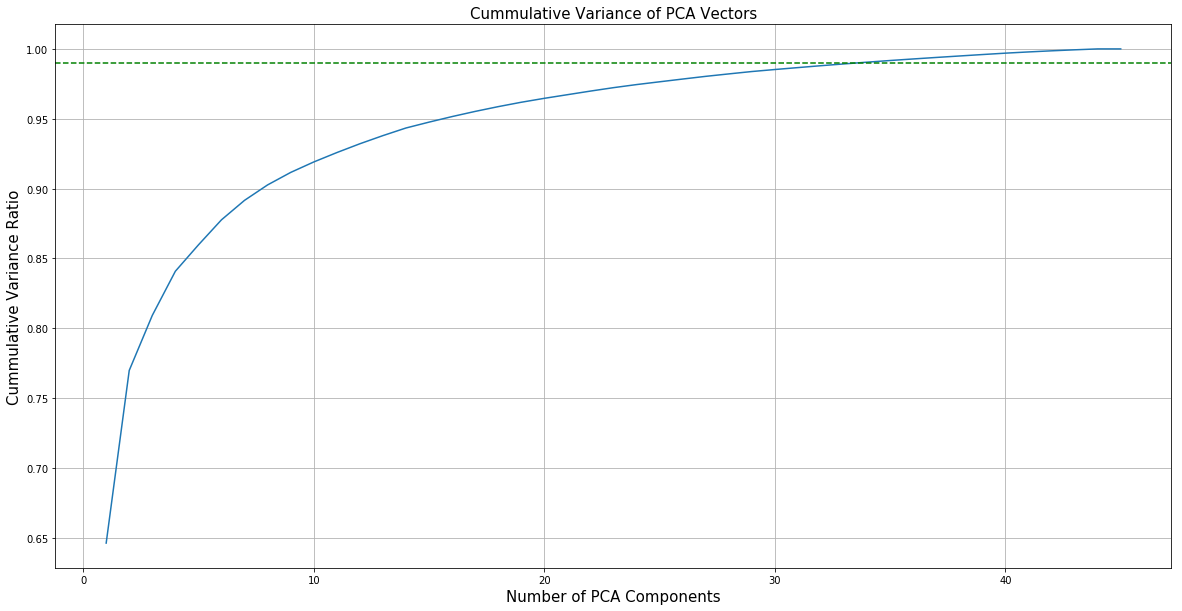

Number of components where sum(pca_var) >= 0.95: 16


In [22]:
plt.figure(figsize=(20,10))
plt.plot(pca_comp, np.cumsum(variance_ratio))
plt.axhline(y=0.99, color='g', linestyle='--')
plt.title('Cummulative Variance of PCA Vectors', fontsize=15)
plt.xlabel('Number of PCA Components', fontsize=15)
plt.ylabel('Cummulative Variance Ratio', fontsize=15)
plt.grid(True)
plt.show()

n_components = 20
accuracy = 0.95
for i, var_sum in enumerate(np.cumsum(variance_ratio)):
    if var_sum >= accuracy:
        n_components = pca_comp[i]
        print(f'Number of components where sum(pca_var) >= {accuracy}: {n_components}')
        break

**_Do you need all vectors to represent the data?_**

No, because trying to compute vectors beyond the size of our training data set (in this case 45 images) will not yield any results and therefore the variance ratio will not change. Additionally, the variance starts off quite high for k=1 components and drops sharply until around k=10 where the decrease becomes more gradual. Therefore we should only need to compute a small subset of vectors in order to represent most of our training data, and we do not need to compute a PCA vector from every component in the training set.

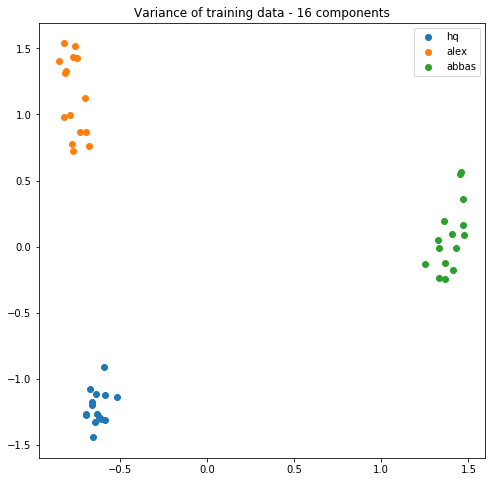

In [12]:
# Compute PCA
pca = PCA(n_components=n_components, whiten=True)
x_pca = pca.fit_transform(x_train_norm)

# Select matching data and plot
plt.figure(figsize=(8,8))
for img_class in train_classes:
    x_class = x_train_pca[y_train == img_class, :]
    plt.scatter(x_class[:,0], x_class[:,1])
plt.title(f'Variance of training data - {n_components} components')
plt.legend(train_classes)
plt.show()

In [13]:
# Use KNeighbours classifier to evaluate clustering on eigenspace and original pixel space
start = time.time()
kn_class = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
kn_class.fit(x_pca, y_train)
pred = kn_class.predict(x_pca)
print(f'Eigenspace accuracy: {accuracy_score(y_train, pred)}')
print(f'Computation time: {time.time()-start}\n')

start = time.time()
kn_class = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
kn_class.fit(x_train, y_train)
pred = kn_class.predict(x_train)
print(f'Pixel space accuracy: {accuracy_score(y_train, pred)}')
print(f'Computation time: {time.time()-start}')

Eigenspace accuracy: 1.0
Computation time: 0.0033719539642333984

Pixel space accuracy: 1.0
Computation time: 0.24144840240478516


As we can see, there is no significant difference between the accuracy of the eigenspace and pixel space representations. However, there is a significant difference in computation time when comparing the reduced eigenspace to the much larger pixel space.

## 3 - Face Detection & Identification

In [14]:
face_h, face_w = face_size
mean_face = pca.mean_.reshape(face_h, face_w)
eigenfaces = pca.components_.reshape((n_components, face_h, face_w))

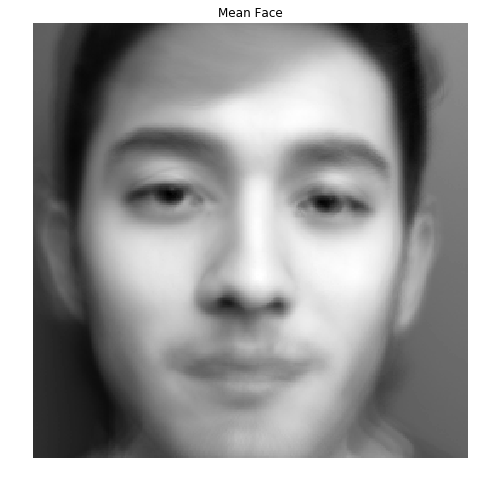

In [15]:
plt.figure(figsize=(8,8))
plt.imshow(mean_face, cmap='gray')
plt.title('Mean Face'), plt.axis('off')
plt.show()

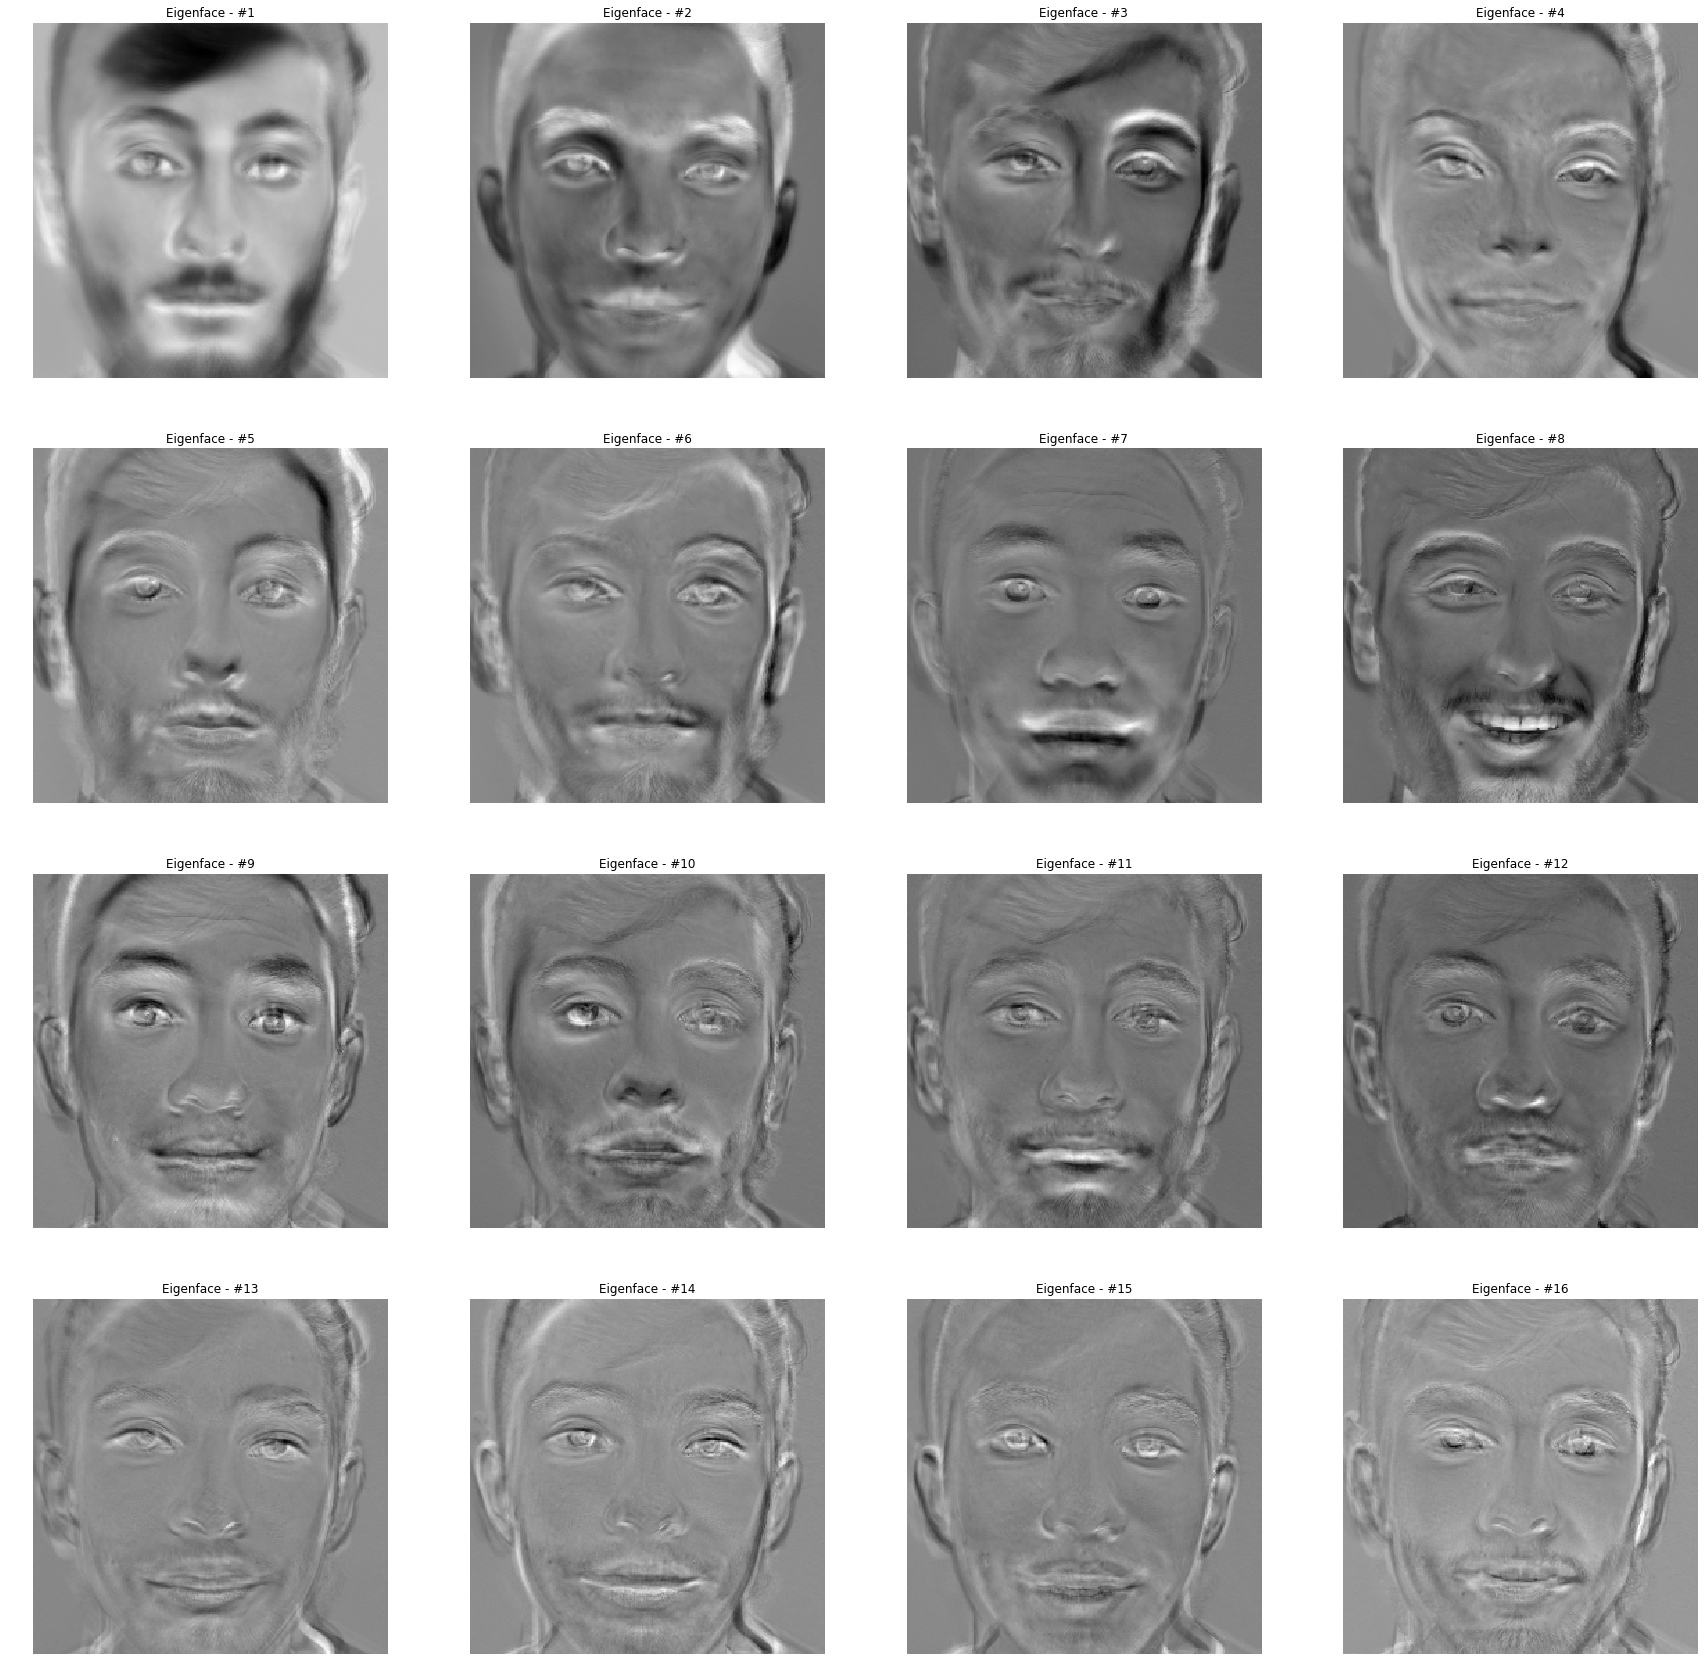

In [16]:
plotFigures(eigenfaces, title='Eigenface')

In [17]:
def project(X, V):
    return np.dot(X, V.T)

In [18]:
def sliding_window(img, window, step=8):
    for y in range(0, img.shape[0], step):
        for x in range(0, img.shape[1], step):
            img_crop = img[y:y+window[1], x:x+window[0]]
            yield (x, y, img_crop)

In [19]:
mean_face_flat = mean_face.ravel()
eigenfaces_flat = eigenfaces.reshape(eigenfaces.shape[0], -1)

num_windows = 0
num_rej = 0
faces_detected = []
test_image_copy = test_img_resized.copy()
norms = []

start = time.time()
for (x, y, img) in sliding_window(test_img_resized, window=face_size, step=32):
# for img in test_detected_faces:
    if img.shape[0] != face_size[0] or img.shape[1] != face_size[1]:
        num_rej += 1
        continue
    
    centered_img = (img - mean_face).ravel()
    coeff = project(centered_img, eigenfaces_flat)
    
    reconstruction = mean_face_flat + np.dot(coeff, eigenfaces_flat)
    
    norm = np.linalg.norm(centered_img - reconstruction)
    norms.append(norm)
#     if norm < 26000:
#         print(norm)
#         faces_detected.append(img)
#         cv2.rectangle(test_image_copy, (x,y), (x+face_size[0],y+face_size[1]), (255,255,255), 4)
    num_windows += 1

print(min(norms))
print(f'Windows Processed: {num_windows}')
print(f'Windows Rejected: {num_rej}')
print(f'Processing time: {(time.time() - start)}')

29587.9865519088
Windows Processed: 1290
Windows Rejected: 648
Processing time: 20.840218544006348


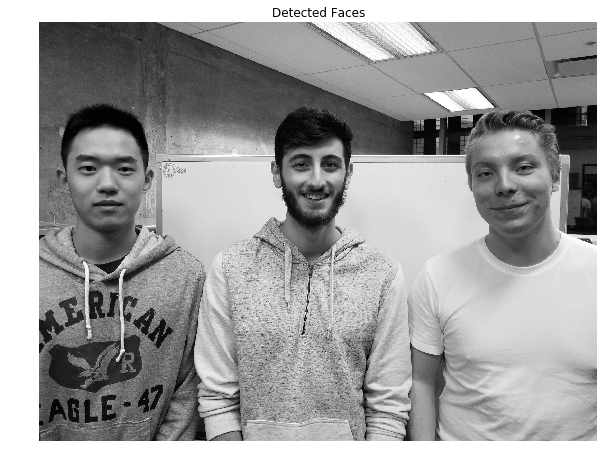

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(test_image_copy, cmap='gray')
plt.title('Detected Faces'), plt.axis('off')
plt.show()

In [21]:
plotFigures(faces_detected, title='Face')

<Figure size 2160x2160 with 0 Axes>

## 4 - Viola-Jones Comparison